<a href="https://colab.research.google.com/github/Dabin-Park/Handson/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8%204%EB%8B%A8%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**4장 – 모델 훈련**

# 선형 회귀

## 선형 회귀 모델을 훈련시키는 두가지 방법
* 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터(즉, 훈련 세트에 대해 비용 함수를 최소화하는 모델 파라미터)를 해석적으로 구한다.
* 경사 하강법(GD)이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훔련 세트에 최소화시킨다.
> * 결국에는 앞의 방법과 동일한 파라미터로 수렴한다.  

In [ ]:
import numpy as np

X = 2 * np.random.rand(100, 1)  # rand : 0부터 1 사이 균일 분포 난수를 matrix array(100,1)로 생성
y = 4 + 3 * X + np.random.randn(100, 1) # randn : 기댓값이 0이고, 표준편차가 1인 가우시안 표준 정규 분포를 따르는 난수 생성

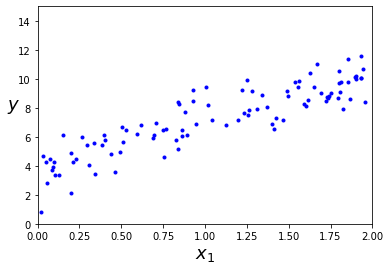

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)    # xlabel 이름
plt.ylabel("$y$", rotation=0, fontsize=18)  #ylabel 이름
plt.axis([0, 2, 0, 15]) # x - axis : 0 ~ 2
                        # y - axis : 0 ~ 15
plt.show()

**식 4-4 : 정규 방정식**

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

In [ ]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다. (c_ : column 추가)
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)    # np.linalg.inv() : 역행렬 구하는 메서드
print(theta_best)

[[3.85295493]
 [3.23466826]]


$\hat{y} = \mathbf{X} \boldsymbol{\hat{\theta}}$

In [ ]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.85295493],
       [10.32229145]])

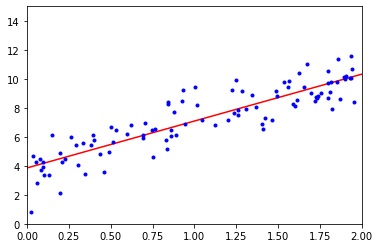

In [ ]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

책에 있는 그림은 범례와 축 레이블이 있는 그래프입니다:

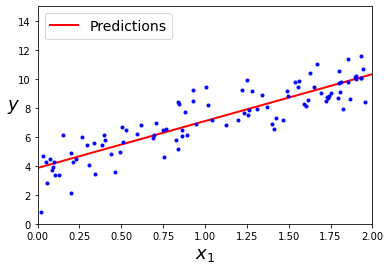

In [ ]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)    # 사이킷런은 특성의 가중치(coef_)와 편향(intercept_)을 분리하여 저장
print(lin_reg.intercept_, lin_reg.coef_)

[3.85295493] [[3.23466826]]


In [ ]:
lin_reg.predict(X_new)

array([[ 3.85295493],
       [10.32229145]])

`LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수("least squares"의 약자)를 사용하므로 이 함수를 직접 사용할 수 있습니다:

In [ ]:
# 싸이파이 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 씁니다.
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.85295493],
       [3.23466826]])

이 함수는 $\mathbf{X}^+\mathbf{y}$을 계산합니다. $\mathbf{X}^{+}$는 $\mathbf{X}$의 _유사역행렬_ (pseudoinverse)입니다(Moore–Penrose 유사역행렬입니다).    
 "np.linalg.pinv()"을 사용해서 유사역행렬을 직접 계산할 수 있습니다:

* 역행렬은 full rank인 n x n square matrix에서만 정의된다.
* square matrix가 아닌 다른 모양의 행렬에서는 역행렬 대신에 유사 역행렬을 정의할 수 있다.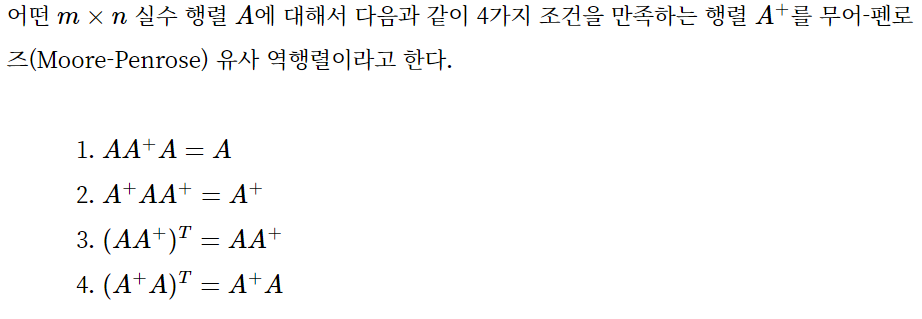
* 특이값 분해(SVD)를 이용하면 유사 역행렬을 쉽게 계산할 수 있다. 


$\boldsymbol{\hat{\theta}} = \mathbf{X}^{-1}\hat{y}$

In [ ]:
np.linalg.pinv(X_b).dot(y)  # np.linalg.pinv() : 유사역행렬을 구해주는 메서드

array([[3.85295493],
       [3.23466826]])

# 경사 하강법


* 특성이 매우 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합한 선형 회귀 모델 훈련 방법 
* 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘
>* 기본 아이디어 : 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것 
 


1. 파라미터 벡터 $\boldsymbol{\theta}$에 대해 비용 함수의 현재 그레디언트를 계산한다.
2. 그레디언트가 감소하는 방향으로 진행한다.
3. 그레디언트가 0이 되면 최솟값에 도달한 것이다.
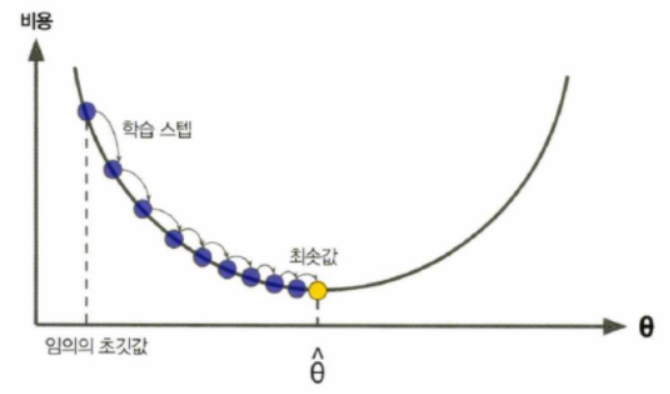

* 경사 하강법에서 중요한 파라미터는 스텝의 크기이다.
* 학습률 하이퍼파라미터로 결정된다.
> * 학습률이 너무 낮으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간이 오래 걸린다.
> * 학습률이 너무 크면 골 짜기를 가로 질러 반대편으로 건너가게 되어 이전보다 더 높은 곳으로 올라가게 될지도 모른다. (알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾지 못하게 한다.)
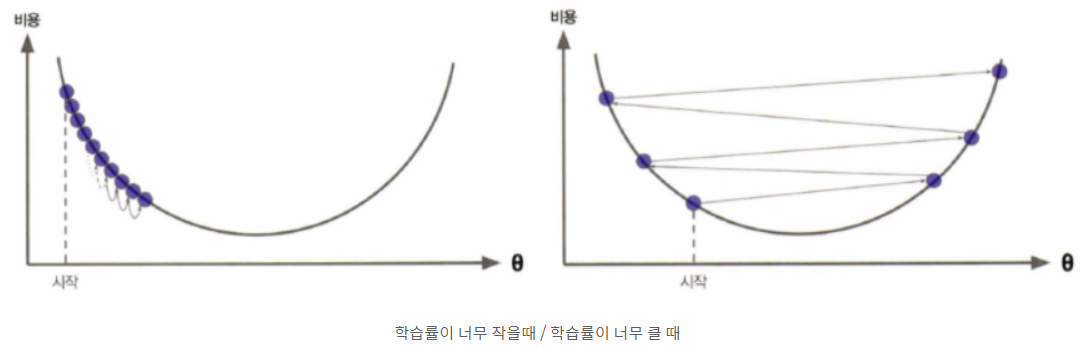

* 모든 비용 함수가 매끈한 그릇과 같지는 않다.
> * 패인 곳, 산마루, 평지 등 특이한 지형이 있으면 최솟값으로 수렴하기 매우 어렵다.
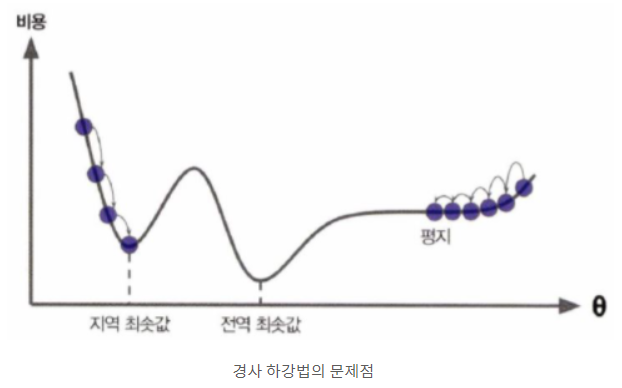
* 알고리즘이 왼쪽에서 시작하면 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴한다.
* 알고리즘이 오른쪽에서 시작하면 평탄한 지역을 지나기 위해 시간이 오래 걸리고 일찍 멈추게 되어 전역 최솟값에 도달하지 못한다. 

* 다행히 선형 회귀를 위한 MSE 비용 함수는 곡선에서 어떤 두 점을 선택해 선을 그어도 곡선을 가로지르지 않는 볼록함수(convex function)이다.
> * 지역 최솟값이 없고 하나의 전역 쇠솟값만 있다는 뜻이다.
> * 연속된 함수이고 기울기가 갑자기 변하지 않는다.
>> * 이 두 사실로부터 경사 하강법이 전역 최솟값애 가깝게 접근할 수 있다는 것을 보장한다.    
(학습률이 너무 높지 않고 충분한 시간이 주어지면)

* 비용함수는 그릇 모양을 하고 있지만 특성들의 스케일이 매우 다르면 길쭉한 모양일 수 있다.
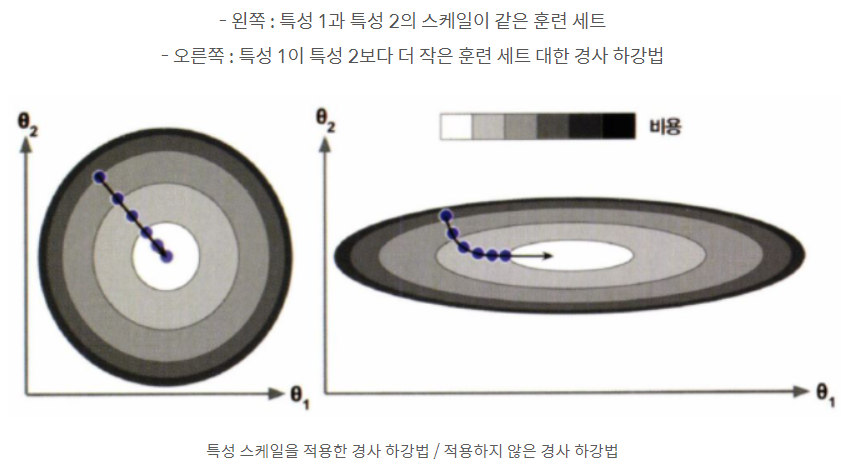
* 왼쪽의 경사 하강법 알고리즘이 최솟값으로 곧장 진행하고 있어 빠르게 도달한다.
* 오른쪽 그래프는 처음엔 전역 최솟값의 방향에 거의 직각으로 향하다가 편한 골짜기를 길게 돌아서 나간다.    
 (결국 최솟값에 도달하겠지만 시간이 오래 걸릴 것이다.)

## 배치 경사 하강법

* 경사 하강법을 구현하려면 각 모델 파라미터 $\boldsymbol{\theta}_j$에 대해 비용 함수의 그레디언트를 계산해야 된다. 

**식 4-6 : 비용 함수의 그레이디언트 벡터**
* 매 경사 하강법 스텝에서 전체 훈련 세트 $\boldsymbol{X}$에 대해 계산한다.    
( 그래서 이 알고리즘을 배치 경사 하강법이라고 한다.)
> * 매우 큰 훈련 세트에서는 아주 느리다.
> * 그러나 경사 하강법은 특성 수에 민감하지 않다.
*  수십만 개의 특성에서 선형 회귀를 훈련시키려면 정규방정식이나 SVD 분해보다 경사 하강법을 사용하는 편이 훨씬 빠르다.

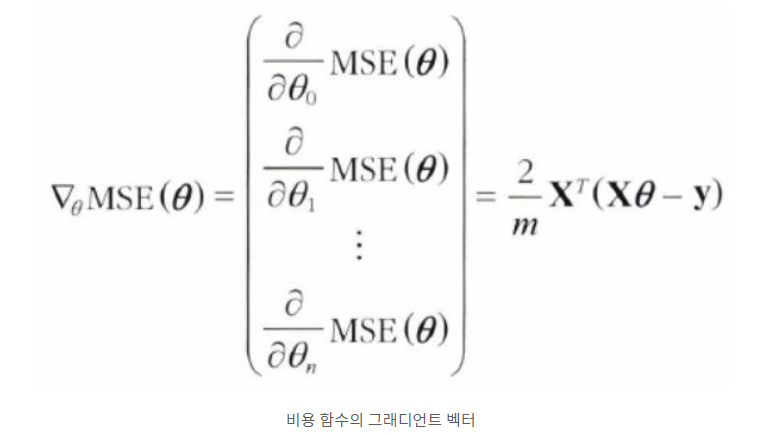

**식 4-7: 경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \nabla_\theta\text{MSE}(\boldsymbol{\theta})
$
> * $\eta$ : 학습률
> * 위로 향하는 그레디언트 벡터가 구해지면 반대 방향인 아래로 가야한다. 
>> * $\boldsymbol{\theta}$에서 $ \nabla_\theta \text{MSE}(\boldsymbol{\theta})$를 빼야 한다는 뜻이다.


In [ ]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

print(theta)

[[3.85295493]
 [3.23466826]]


In [ ]:
X_new_b.dot(theta)

array([[ 3.85295493],
       [10.32229145]])

In [ ]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

#### 아래의 그림은 세 가지 다른 학습률을 사용하여 진행한 경사 하강법의 스텝 처음 10개를 보여준다.
> * 왼쪽은 학습률이 너무 낮다.
>> * 알고리즘은 최적점에 도달하겠지만 시간이 오래걸린다.
> * 가운데는 학습률이 아주 적당하다.
>> * 반복 몇 번 만에 이미 최적점에 수렴했다.
> * 오른쪽은 학습률이 너무 높다.
>> * 알고리즘이 이리저리 널뛰면서 ㅅ텝미다 최적점에서 점점 더 멀어져 발산한다.


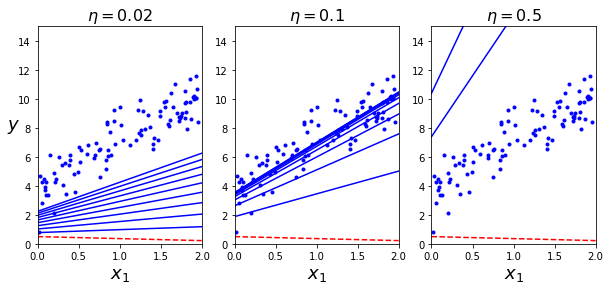

In [ ]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

* 적절한 학습률을 찾으려면 그리드 탐색을 사용해야 된다. (모든 학습률을 넣어보고 비교하는것)
> * 그리드 탐색에서 수렴하는 데 오래 걸리는 모델을 막기 위해 반복 횟수를 제한해야 한다.

* 반복횟수가 너무 작으면 최적점에 도달하기 전에 알고리즘이 멈춘다.
* 너무 크면 모델 파라미터가 더는 변동하지 않는 동안 시간을 낭비한다.
* 해결법 
> * 반복횟수를 아주 크게 지정 하고 그레디언트 벡터가 아주 작아지면 경사하강법이 (거의) 최솟값에 도달한 것이므로 알고리즘을 중지한다. 

## 확률적 경사 하강법

* 배치 경사 하강법의 가장 큰 문제는 매 스텝에서 전체 훈련 세트를 사용해 그레디언트를 계산한다는 것이다.
> * 훈련 세트가 커지면 매우 느려지게 된다. 
* 이와는 정반대로 **확률적 경사 하강법**은 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레디언크를 계산한다. 
> * 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플을 처리하면 알고리즘이 훨씬 빠르다.
> * 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련 세트도 훈련시킬 수 있다.    
(SGD는 외부 메모리 학습 알고리즘으로 구현할 수 있다.)
> * 확률적(즉, 무작위)이므로 이 알고리즘은 배치 경사 하강법보다 훨씬 불안정하다.

* 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치며 평균적으로 감소한다.
* 시간이 지나면 최솟값에 매우 근접하겠지만 요동아 자속 되면서 최솟값에 안착되지 못한다.    
(알고리즘이 멈출 때 좋은 파라미터가 구해지겠지만 최적치는 아니다.)
* 비용 함수가 불규칙한 특징을 갖고 있을 때(패인 곳, 산마루, 평지 등) 지역 최솟값을 뛰어넘을 수 있기 때문에 배치 경사 하강법보다 전역 최솟값을 찾을 가능성이 높다.
* 무작위성은 지역 최솟값에서 탈출시켜줘서 좋지만 알고리즘을 전역 최솟값에 다다르지 못하게 한다는 점에서는 좋지 않다.
* 해결법
> * 학습률을 점진적으로 감소시키는 방법입니다.
> * 시작할 때는 학습률을 크게 하여 수렴이 빠르게 이뤄질 수 있도록 도와주고, 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하게 한다.



* 매 반복에서 학습률을 결정하는 함수를 **학습 스케줄**(learning schedule)이라고 부른다.
> * 학습률이 너무 빨리 줄어들면 지역 최솟값에 갇히거나 최솟값까지 가는 중간에 멈춰 버릴 수도 있다.
> * 학습률이 너무 천천히 줄어들면 오랫동안 최솟값 주변을 맴돌거나 훈련을 너무 일찍 중지해서 지역 최솟값에 머무룰 수 있다.

In [ ]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

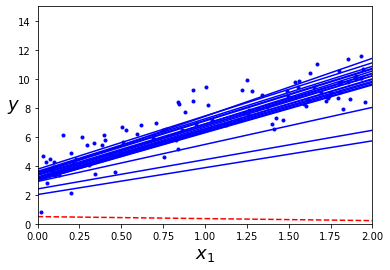

In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                   
            y_predict = X_new_b.dot(theta)          
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                    
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
plt.show()                                          

* 샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 에포크에서 여러 번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못 할 수도 있다.
> * 알고리즘이 에포크마다 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후(입력 특성과 레이블을 동일하게 섞어야 한다.) 차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 밥법을 사용할 수 있다.    
(사이킷런의 SGDClassifier와 SGDRegressor가 사용하는 방법이다.)
>> * 이렇게 하면 보통 더 늦게 수렴한다.


In [ ]:
theta

array([[3.80914523],
       [3.23048418]])

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)    # max_iter = 1000 : 최대 1,000번 에포크 동안 실행
                                                                                            # tol = 1e-3 : 한 에포크에서 0.001보다 적게 솔실이 줄어들 때까지 실행
                                                                                            # eta0 = 0.1 : 학습률 0.1
                                                                                            # penalty = None : 규제는 없다.
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.83380511]), array([3.22497769]))

## 미니배치 경사 하강법

* 각 스텝에서 전체 훈련 세트(경사 하강법)나 하나의 샘플(확률적 경사 하강법)을 기반으로 그레디언트를 계산한것이 아니라    
 **미니 배치**라 불리는 임의의 작은 샘플 세트에 대해 그레티언트를 계산한다.
 > * 확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 장점은 행렬 연산에 최적화된 하드웨어,    
  특히 GPU를 사용하여 얻은 성능 향상이다.

* 미니배치를 어느정도 크게 하면 이 알고리즘은 파라미터 공간에서 SGD보다 덜 불규칙 하게 움직인다.
> * 결국 미니배치 경사 하강법이 SGD보다 최솟값에 더 가까이 도달하게 될 것이다.
> * 하지만 지역 최솟값에서 빠져 나오기는 더 힘들지도 모른다(선형 회귀와 같지 않고 지역 최솟값이 문제가 되는경우).

In [ ]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [ ]:
theta

array([[3.86060135],
       [3.23131283]])

In [ ]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

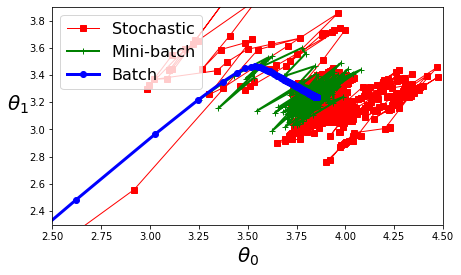

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

#### 알고리즘을 선형 회귀를 사용해 비교한 표 
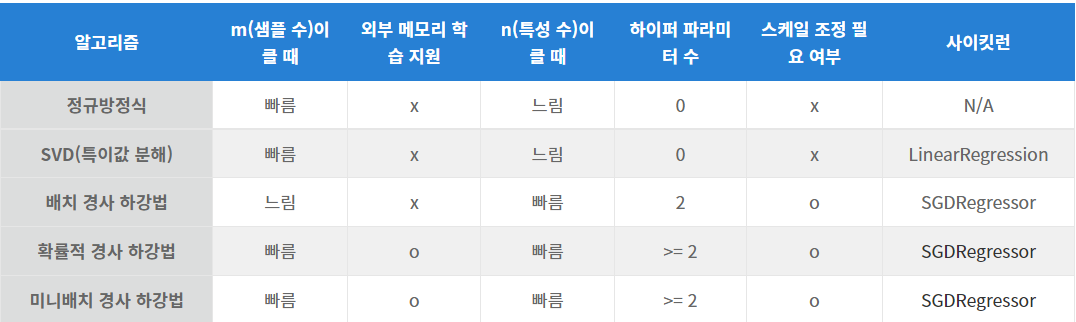

# 다항 회귀

선형 회귀보다 파라미터가 많아서 훈련 데이터에 과대적합되기 더 쉽다.
> * 학습 곡선을 사용해 모델이 과대적합되는지 감지할 수 있다.


* 비선형 데이터를 학습하는 데 선형 모델을 사용 할 수 있다.
> * 다항 회귀
>> * 각 특성의 거듭제곧을 새로운 특성으로 추가하고,     
이 확장된 특성을 포함한 데이터 셋에 선형 모델을 훈련시킨다.

In [ ]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [ ]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)  # 2차방정식으로 비선형 데이터 생성(약간의 잡음 포함)

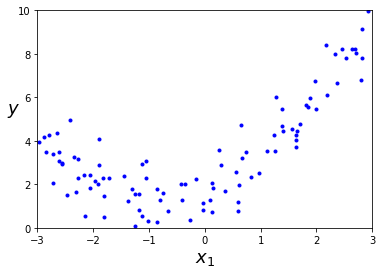

In [ ]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures    # 사이킷런의 PolynomialFeatures를 사용해 훈련 데이터를 변환 
                                                        # PolynomialFeatures의 매개변수 degree의 기본값은 2이고 indlude_bias의 기본값은 True이다.
                                                        # indlude_bias = True : 편향을 위한 특성(x_0)인 1이 추가된다.
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X) # 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가 (여기서는 특성 하나가 추가된다.)
print(X[0],X_poly[0])   

[-0.75275929] [-0.75275929  0.56664654]


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

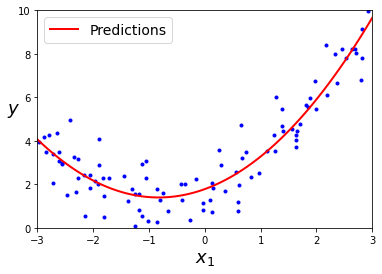

In [ ]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

* 특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있다(일반적인 선형 회귀 모델에서는 하지 못한다.).
> * PolynomialFeatures가 주어진 차수 까지 특성 간의 모든 교차항을 추가 하기 떄문이다.
>> * 예를 들어 두 개의 특성 a, b가 있을 때 degree = 3으로 PolynomialFeatures를 적용하면 $a^2, a^3, b^2, b^3$뿐만 아니라 $ab, a^2b,ab^2$도 특성으로 추가 한다. 

# 학습 곡선

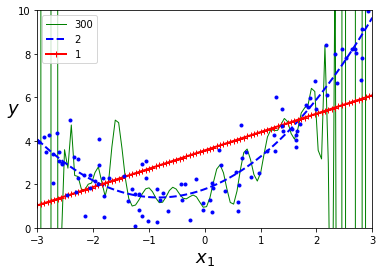

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

$\uparrow$
* 초록색 : degree = 300
* 파랑색 : degree = 2
* 빨강색 : degree = 1
> * degree = 300일때는 훈련 데이터에 과대적합되었다.
> * degree = 1일때는 훈련 데이터에 과소적합되었다.

* 학습 곡선 
> * 훈련 세트와 검증세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타낸 것.
> * 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 된다. 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10) # X_val : 검증세트
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

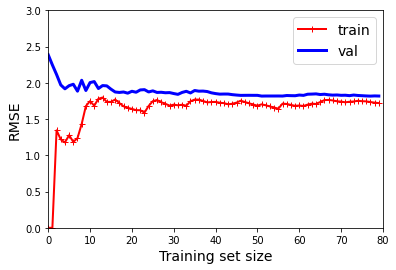

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                       
plt.show()                                      

$\uparrow$ 과소적합 : RMSE값이 크다.

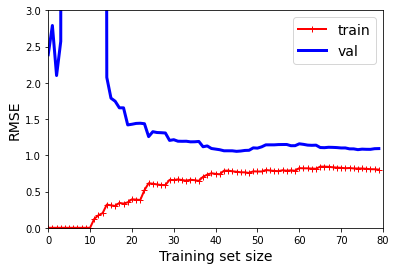

In [ ]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
plt.show()                       

$\uparrow$ 과대적합 : 테스트와 검증의 차이가 많이 난다. 


이 학습곡성은 이전과 비슷해 보이지만 두 가지 매우 중요한 차이점이 있다
> 1. 훈련 데이터의 오차가 선형 회귀 보다 훨씬 낮다.
> 2. 두 곡선 사이에 공간이 있다 
>> * 훈련 데이터에서의 모델 성을이 검증 데이터에서의 모델 성능 보다 훨씬 낮다.
>>> * 과대적합 모델의 특징이다.
>> * 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워 진다 (과대적합을 해소시킨다.).  

#### 편향/분산 트레이드오프
* 통계학과 머신러닝에서 나온 중요한 이론 하나는 모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있다는 사실이다.
> 1. 편향 (bias아님)
>> * 일반화 오차 중에서 편향은 잘못된 가정으로 인한 것이다.   
(예를 들어 데이터가 실제로는 2차인데 선형으로 가정하는 경우이다.)
>> * 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉽다.
> 2. 분산 
>> * 분산은 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타난다.
>> * 자유도가 높은 모델(예를 들면 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있다.
> 3. 줄일 수 없는 오차 
>> * 줄일 수 없는 오차는 데이터 자체에 있는 잡음 때문에 발생한다.
>> * 이 오차를 줄일 수 있는 유일한 방법은 데이터에서 잡음을 제거하는 것이다.    
(예를 들어 고장 난 센서 같은 데이터 소스를 고치거나 이상치를 감지해 제거한다.)  


* 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향은 줄어든다.
* 반대로 모델의 복잡도가 줄어들면 평향이 커지고 분산이 작아진다.
> * 그래서 트레이드오프라고 부른다. 


# 규제가 있는 선형 모델

* 과대적합을 감소시키는 좋은 방법은 모델의 규제를 하는것이다. (즉, 모델을 제한한다.)
* 자유도를 줄이면 데이터에 과대적합되기 더 어려워진다.
* 다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것이다.
* 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가한다.


## 릿지 회귀(또는 티호노프 규제)
* 규제가 추가된 선형 회귀 버전
> * 규제항 $ \displaystyle \alpha \sum^n_{i=1} \theta^2_i$이 비용 함수에 추가된다.
> * 이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력한다.
> * 규제항은 훈련하는 동안에만 비용 함수에 추가된다.
> * 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능지표로 평가한다.

**식 4-8: 릿지 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

 * 하이퍼파라미커 $\alpha$는 모델을 얼마나 규제할지 조절한다. 
 * $\alpha = 0$이면 릿지 회귀는 선형 회귀와 같아진다.
 * $\alpha$가 아주 크면 모든 가중치가 거의 $0$에 가까워지고 결국 데이터의 평균을 지나는 수평선이 된다.

In [ ]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

* 릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 수행하기 전에 데이터의 스케일을 맞추는 것이 중요하다.    
(규제가 있는 모델의 대부분 마찬가지다.)

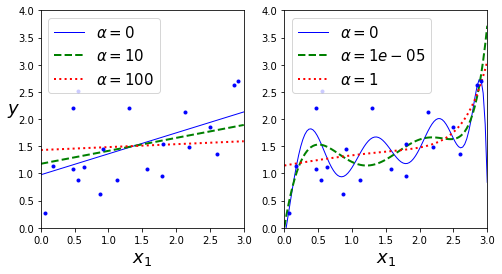

In [ ]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

$\uparrow$ 
* 왼쪽 그래프는 평범한 릿지 모델을 사용해 선형적인 예측을 만든것이다.
* 오른쪽 그래프는 PolynomialFeatures(degree=10)을 사용해 먼저 데이터를 확장하고    
StandardScaler를 사용해 스케일을 조정한 후 릿지 모델을 적용했다.    
(결국 이는 릿지 규제를 사용한 다항 회귀가 된다.)
> * $\alpha$를 증가시킬수록 직선에 가까워지는 것을 볼 수 있다.
> * 즉, 모델의 분산은 줄지만 편향은 커지게 된다.

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)  # 행렬분해를 사용
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [ ]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

**노트**: 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.21 버전의 기본값인 `max_iter=1000`과 `tol=1e-3`으로 지정합니다.

In [ ]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)  # penalty 매개변수는 사용할 규제를 지정한다.
                                                                                # 'l2'는 SGD가 비용함수에 가중치 벡터의 l_2 노름의 제곱을 2로 나눈 규제항을 추가하게 만든다.
                                                                                # 즉, 릿지 회귀롸 같다.
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

## 라쏘 회귀
* 선형 회귀의 또 다른 규제된 버전이다.
* 가중치 벡터의 l_1노름을 사용하여 비용 함수에 규제항을 더한다.

**식 4-10: 라쏘 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


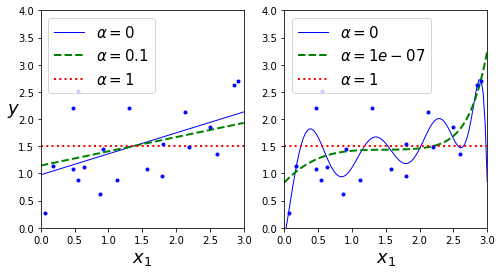

In [ ]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
plt.show()

$\uparrow$
* 릿지 모델과 비슷하지만 조금 더 작은 $\alpha$값을 사용했다.

### 라쏘 회귀의 중요한 특징 
* 덜 중요한 특성의 가중치를 제거하려고 한다는 점이다.   
(즉, 가중치가 $0$이 된다.)
* 예를들어 위의 오른쪽 그래프를 보면 녹색 점선($\alpha = 10^{-7}$)은 3차방정식처럼 보인다.
> * 차수가 높은 다항 특성의 가중치가 모두 $0$이 되었다.


* 라쏘 회귀는 자동으로 특겅 선택을 하고 **희소 모델**을 만든다.    
(즉, $0$이 아닌 특성의 가중치가 적다.)

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)    # Lasso 대신 SGDRegressor(penalty="l1")을 사용해도 된다.
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

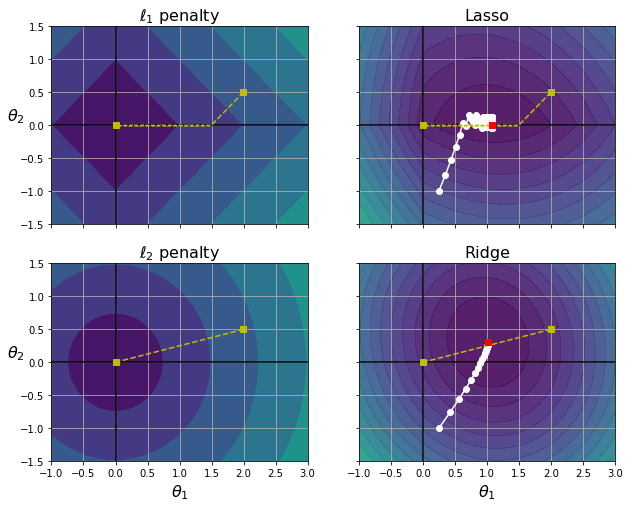

In [ ]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
plt.show()

## 엘라스틱넷
* 릿지 회귀와 라쏘 회귀를 절충한 모델이다.
* 규제항은 릿지와 라쏘의 규제항을 단순히 더해서 사용하며, 혼합정도는 혼합비율 r을 사용해 조절한다.
> * r $= 0$ 이면 엘라스틱넷은 릿지 회귀와 같다.
> * r $ = 1$ 이면 엘라스틱넷은 라쏘 회귀와 같다.

**식 4-12: 엘라스틱넷 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$

* 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 낫다.    
(불필요한 특성의 가중치를 $0$으로 만들어주기 때문)
> * 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로     
라쏘보다는 엘라스틱넷을 선호한다.
>> * 라쏘는 특성 수가 샘플 수(n) 보다 많으면 최대 n개의 특성을 선택한다.
>> * 또한 여러 특성이 강하게 연관되어 있으면 이들 중 임의의 특성 하나를 선택한다.

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)  # l1_ratio가 혼합 비율 r이다.
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## 조기 종료
* 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

In [ ]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

* 조기 종료를 위한 기본적인 구현 코드 

In [ ]:
from copy import deepcopy   ## 책에는 from sklearn import cone 으로 하고 

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,  # warm_start = True로 지정하면 fit() 메서드가 호출될 때 처음부터 다시 시작하지 않고
                                                                    #   이전 모델 파라미터에서 훈련을 이어간다. 
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)  ## 여기서 best_model = clone(sgd_reg) 으로 함

그래프를 그립니다:

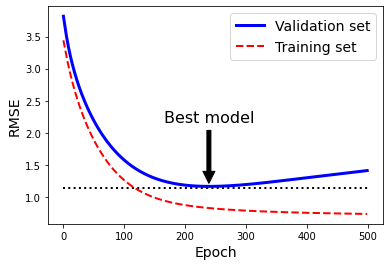

In [ ]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

$\uparrow$
* 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측에러(RMSE)와 검증세트에 대한 예측 에러가 줄어든다.
* 그러나 잠시 후 감소하던 검증 에러가 멈추었다가 다시 상승한다. 
> * 모델이 훈련 데이터에 과대적합되기 시작하는 것을 의미한다. 
* 조기 종료는 검증에러가 최소에 도달하는 즉시 훈련을 멈추는 것이다.

* 확률적 경사 하강법이나 미니배치 경사 하강법에서는 곡선이 그리 매끄럽지 않아 최솟값에 도달했는지 확인 하기 어려울 수 있다 .
> 해결책
> * 검증 에러가 일정 시간 동안 최솟값보다 클 때(모델이 더 나아지지 않는다고 확신이 들 때)     
학습을 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리는 것이다.  

In [ ]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

# 로지스틱 회귀
* 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용된다. 
> * 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측한다. (즉, 레이블이 '1'인 **양성 클래스**)
> * 아니면 클래스에 속하지 않는다고 예측한다. (즉, 레이블이 '0'인 **음성 클래스**)
* 이를 이진 분류기라고 한다. 


* 선형 회귀 모델과 같이 로지스틱 회귀 모델의 입력 특성의 가중치 합을 계산한다.(그리고 편향을 더한다.)
* 대신 선형 회귀 처럼 바로 결과를 출력하지 않고 결괏값의 **로지스틱**을 출력한다. 
> * 로지스틱 ($\sigma(\cdot)$로 표시한다.)은 0과 1 사이의 값을 출력하는 **시그모이드 함수** 이다.

**식 4-13 : 로지스틱 회귀 모델의 확률 추정(벡터 표현식)**

$
\hat{p}  = h_\boldsymbol{\theta}(\mathbf{x}) =  σ(\boldsymbol{\theta}^\perp \mathbf{x})
$

**식 4-14 : 로지스틱 함수**

$
\displaystyle σ(t) = \frac{1}{1 + \exp(-t)}
$

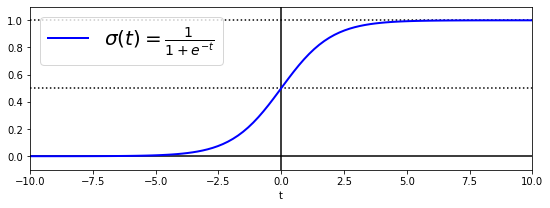

In [ ]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

* 로지스틱 회귀 모델이 샘플 $\mathbf{x}$가 양성 클래스에 속할 확률 $\hat{p} = h_\boldsymbol{\theta}(\mathbf{x})$를 추정하면 이에 대한 예측 $\hat{y}$을 쉽게 구할 수 있다.


**식 4-15 : 로지스틱 회귀 모델 예측**

$
\hat{y} = 
\begin{cases}
 0 &  \hat{p} < 0.5\text{일 때 } \\
 1 & \hat{p} \geq 0.5\text{일 때 }
\end{cases}
$

* $t < 0$ 이면 $\sigma(t) < 0.5$이고, $t \geq 0$ 이면 $\sigma(t) \geq 0.5$이므로 로지스틱 회귀 모델은     
$\boldsymbol{\theta}^T \mathbf{x}$ 가 양수일 때 1(양성 클래스)이라고 예측, 음수일 때 0(음성 클래스)이라고 예측한다. 

### 로지스틱 회귀 모델을 훈련 시키는 방법 
* 양성 샘플($y=1$)에 대해서는 높은 확률을 추정하고 음성 샘플($y=0$)에 대해서는 낮은 확률을 추정하는     
모델의 파라미터 벡터 $\boldsymbol{\theta}$를 찾는것이다.


**식 4-16 : 하나의 훈련 샘플에 대한 비용 함수**

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) &  y = 1 \text{ 일 때}, \\
  -\log(1 - \hat{p}) & y = 0 \text{ 일 때}.
\end{cases}
$

* 이 비용 함수는 $t$가 0에 가까워지면 $-\log(t)$가 매우 커지므로 타당하다 할 수 있다.
> * 양성 샘플을 0에 가까운 확률로 추정하면 비용이 크게 증가
> * 음성 샘플을 1에 가까운 확률로 추정하면 비용이 크게 증가

* 반면에 $t$가 1에 가까우면 $-\log(t)$는 0에 가까워 진다 .
> * 양성 샘플을 1에 가까운 확률로 추정하면 비용이 0에 가까워 진다.    
> * 음성 샘플을 0에 가까운 확률로 추정하면 비용이 0에 가까워 진다.
  

* 전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것이다.

**식 4-17 : 로지스틱 회귀 비용 함수(로그 손실)**

$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$

#### 로지스틱 회귀의 비용함수는 정규방정식 같은 비용 함수의 최솟값을 계산하는 알려진 해가 없다.
 * 하지만 이 비용 함수는 볼록 함수이므로 경사 하강법(또는 어떤 다른 최적화 알고리즘)이 전역 최솟값을 찾는것이 보장된다.    
(학습률이 너무 크지 않고 충분히 기다릴 시간이 있다면) 

**식 4-18 : 로지스틱 비용 함수의 편도 함수**

$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$

## 결정 경계

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [ ]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(int)  # Iris virginica이면 1 아니면 0 : 이진 분류 

**노트**: 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.22 버전의 기본값인 `solver="lbfgs"`로 지정합니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

<function matplotlib.pyplot.show>

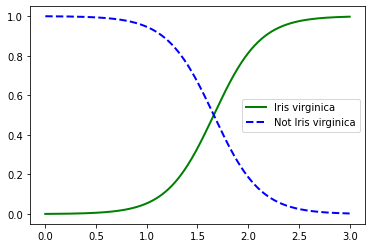

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # 꽃잎의 너비가 0 ~ 3cm인 꽃
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.legend()
plt.show

책에 실린 그림은 조금 더 예쁘게 꾸몄습니다:

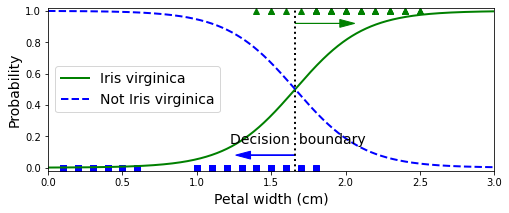

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")    # 아래의 파란 사각형 
plt.plot(X[y==1], y[y==1], "g^")    # 위의 초록 삼각형   
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

$\uparrow$
* 2cm 이상인 꽃은 분류기가 Iris virginica라고 강하게 확신한다. 
* 반면 1cm 이하면 Iris virginica가 아니라고 강하게 확신한다. 
> * 이 두 극단 사이에서는 분류가 확실하지 않다.





* 하지만 어쩃든 클래스를 예측 하려고 하면(predict_proba() 메서드 대신 predict() 메서드를 사용해서)    
 가장 가능성이 높은 클래스를 반환할 것이다. 
> * 그렇기 때문에 양쪽의 확률이 똑같이 50% 가 되는 1.6cm 근방에서 **결정경계**가 만들어진다. 
>> * 꽃잎 너비가 1.6cm보다 크면 분류기는 Iris virginica로 분류하고,     
그보다 작으면 아니라고 예측할 것이다. (아주 확실하지 않더라도)

In [ ]:
decision_boundary

array([1.66066066])

In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

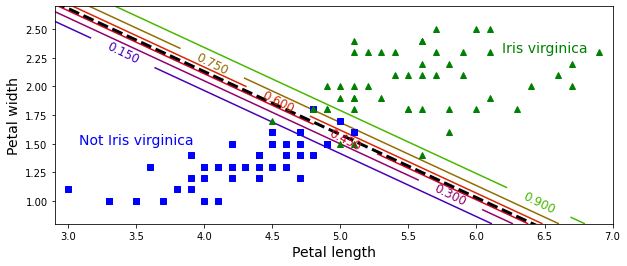

In [ ]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

## 소프트맥스 회귀

* 로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있다.
> * 소프트맥스 회귀 또는 다항 로지스틱 회귀라고 한다.

**식 4-19 : 클래스 k에 대한 소프트맥스 점수**

$
\mathbf{s}_k(\mathbf{x}) = \left( \theta^{(k)}\right)^T \mathbf{x}
$
> * 각 클래스는 자신만의 파라미터 벡터 $\theta^{(k)}$가 있다.
> * 이 벡터들은 파라미터 행렬 $𝚯$에 행으로 저장 된다. 

**식 4-20: 소프트맥스 함수**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$
> * K : 클래스 수
> * $s(\mathbf{x})$ : 샘플 $\mathbf{x}$에 대한 각 클래스의 점수를 담은 벡터
> * $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k$ : 샘플 $\mathbf{x}$에 대한 각 클래스의 점수가 주어졌을 때 이 샘플이 클래스 k에 속할 추정 확률

**식 4-21: 소프트맥스 회귀 분류기의 예측**

$
\hat{y} = \text{argmax}_{(k)}\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \text{argmax}_{(k)} \mathbf{s}_k(\mathbf{x}) =  \text{argmax}_{(k)}\left( \left( \theta^{(k)}\right)^T\mathbf{x} \right)
$
> * 로지스틱 회귀 분류기와 마찬가지로 소프트맥스 회귀 분류기는 [식 4-21]처럼 추정 확률이 가장 높은 클래스를 선택한다.

* 모델이 타깃 클래스에 대해서는 높은 확률을(그리고 다른 클래스에 대해서는 낮은 확률을) 추정하도록 만드는것이 목적이다.

**식 4-22: 크로스 엔트로피 비용 함수**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$
> * 크로스 엔트로피 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제 하므로 이 목적에 부합하다.
> * 크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용 된다.
> * 딱 두 개의 클래스가 있을 때(K = 2) 이 비용 함수는 로지스틱 회귀의 비용 함수와 같다.

**식 4-23: 클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

In [ ]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)   # multi_class = "multinomial" : 소프트맥스 회귀
softmax_reg.fit(X, y)                                                                               # 소프트맥스 회귀를 사용 하려면 solver 메개변수에 "lbfgs"와 같은 
                                                                                                    #       소프트맥스 회귀를 지원하는 알고리즘을 지정해야 된다.
                                                                                                    # 기본적으로 하이퍼파라미터 C를 사용하여 조절할 수 있는 l_2 규제가 적용된다.

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [ ]:
softmax_reg.predict([[5, 2]])  

array([2])

In [ ]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

$\uparrow$ 꽃잎 길이가 5cm, 꽃잎 너비가 2cm인 붓꽃을 발견 했다고 가정하면

모델은 94.2%의 확률로 Iris-Virginica(클래스2)라고 출력할 것이다.

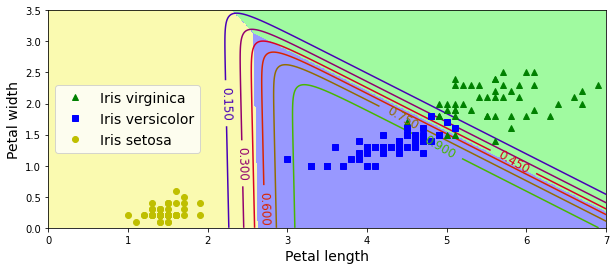

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

$\uparrow$ 클래스 사이의 결정 경계가 모두 선형이다.

또한 Iris-Versicolor 클래스에 대한 확률을 곡선으로 나타냈다.    
(즉, 0.450인 직선은 45% 확류 경계를 나타낸다.)

이 모델이 추정 활률 50% 이하인 클래스를 예측할 수도 있다는 점을 주목하라
> * 예를 들어 모든 결정 경계가 만나는 지점에서는 모든 클래스가 동일하게 33%의 추정 확률을 가진다.